# Cats and Dogs

In this notebook we will train a model to classify cats vs dogs using transfer learning from a pre-trained network.

This notebook is divided in the following steps:

    1. Dataset loading and preprocessing;
    2. Compose the model using a pretrained feature extraction model (base model) with pretrained weights and a classification layer on top;
    3. Train our model;
    4. Evaluate the model;
    5. Run inference against a set of downloaded images.

In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tabulate import tabulate

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras

/home/bml/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bml/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bml/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bml/miniconda3/envs/tf/lib/python3.6/site-packages/tensorf

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.enable_eager_execution()

## Dataset

We will use the `tensorflow-datasets` package to load the cats and dogs dataset. Because this dataset is not split into train/validation/test, we will split it ourselves.


In [3]:
SPLIT_HEIGHTS = (8, 1, 1)
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [5]:
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_HEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.0) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_validation.map(format_example)

### Example data

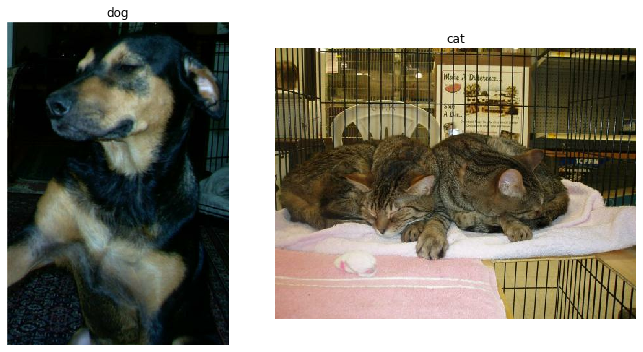

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for idx, (image, label) in enumerate(raw_train.take(2)):
    ax[idx].imshow(image)
    ax[idx].axis('off')
    ax[idx].set_title(metadata.features['label'].int2str(label))
plt.tight_layout()

### Batches

Batches are sets of input data (in this case, images) that are loaded into the model simultaneously. The batch size depends mostly on the memory of the gpu.

In [10]:
BATCH_SIZE = 64
SUFFLE_BUFFER_SIZE = 1000

In [8]:
train_batches = train.shuffle(SUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(SUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.shuffle(SUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

### Model

We will create a model from a MobileNetV2 pretrained network and a simple dense classifier.

In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1),
])

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10
    for weight in SPLIT_HEIGHTS)

In [14]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

In [15]:
validation_batches = train.shuffle(SUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

loss, accuracy = model.evaluate(validation_batches, steps=validation_steps)
print("initial model performance:")
print("  loss: {:.2f}".format(loss))
print("  accuracy: {:.2f}".format(accuracy))


20/20 [==============================] - 4s 202ms/step - loss: 5.7079 - acc: 0.4172
initial model performance:
  loss: 5.71
  accuracy: 0.42


## Training

In [16]:
history = model.fit(train_batches,
                    epochs=initial_epochs)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
582/582 [==============================] - 32s 55ms/step - loss: 3.2082 - acc: 0.6169
Epoch 2/10
582/582 [==============================] - 30s 51ms/step - loss: 1.1611 - acc: 0.8370
Epoch 3/10
582/582 [==============================] - 30s 51ms/step - loss: 0.8210 - acc: 0.8856
Epoch 4/10
582/582 [==============================] - 30s 51ms/step - loss: 0.6673 - acc: 0.9101
Epoch 5/10
582/582 [==============================] - 30s 51ms/step - loss: 0.5887 - acc: 0.9209
Epoch 6/10
582/582 [==============================] - 30s 51ms/step - loss: 0.5393 - acc: 0.9281
Epoch 7/10
582/582 [==============================] - 30s 51ms/step - loss: 0.5104 - acc: 0.9342
Epoch 8/10
582/582 [==============================] - 30s 51ms/step - loss: 0.4944 - acc: 0.9369
Epoch 9/10
582/582 [================

In [17]:
loss, accuracy = model.evaluate(validation_batches, steps=validation_steps)
print("final model performance:")
print("  loss: {:.2f}".format(loss))
print("  accuracy: {:.2f}".format(accuracy))

20/20 [==============================] - 2s 91ms/step - loss: 0.2897 - acc: 0.9594
final model performance:
  loss: 0.29
  accuracy: 0.96


### Save the model

In [25]:
model.save('models/cats_and_dogs.h5')

## Inference

In [4]:
ls

cats_and_dogs_inference.py  cats_and_dogs_model.h5  images/
cats_and_dogs.ipynb         cats_and_dogs_train.py  models/


In [5]:
model = keras.models.load_model('cats_and_dogs_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
images_names = list(Path('images').glob('*.jpg'))

def read_image(image):
    image = Image.open(image).resize((IMG_SIZE, IMG_SIZE))
    return np.array(image)

images = np.stack([read_image(img) for img in images_names])

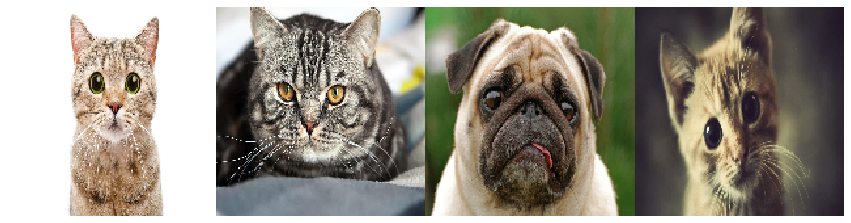

In [7]:
plt.figure(figsize=(15, 10))
plt.imshow(np.hstack(images))
plt.axis('off')
plt.show()

In [8]:
batch = (images / 127.0) - 1.0
batch.shape

(4, 160, 160, 3)

In [9]:
predictions = (model
               .predict(batch)
               .flatten())

In [10]:
results = [
    { 'image': image,
      'prediction': prediction,
      'animal': 'dog' if prediction > 0 else 'cat' }
    for image, prediction in zip(images_names, predictions)
]

In [11]:
from IPython.display import HTML, display
HTML(tabulate(results, headers='keys', tablefmt='html'))

image,prediction,animal
images/cat-01.jpg,-4.22902,cat
images/cat-02.jpg,-4.20901,cat
images/dog-01.jpg,1.18861,dog
images/cat-istock.jpg,-3.9515,cat


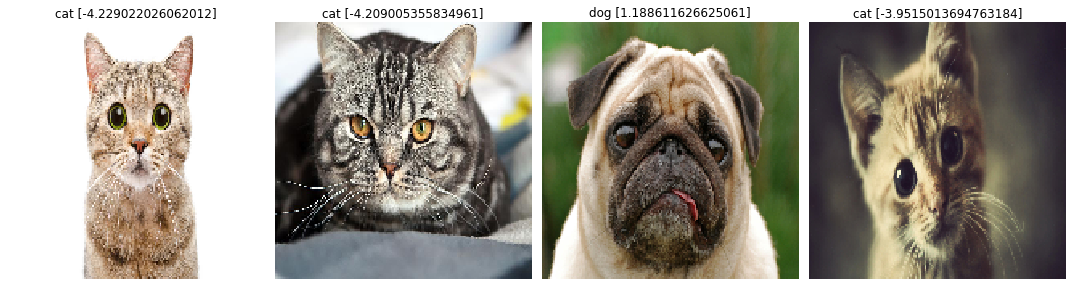

In [12]:
fig, ax = plt.subplots(1, len(images_names), figsize=(15, 10))
for idx, (image, prediction) in enumerate(zip(images, predictions)):
    animal = 'dog' if prediction > 0 else 'cat'

    ax[idx].imshow(image)
    ax[idx].axis('off')
    ax[idx].set_title(f'{animal} [{prediction}]')
plt.tight_layout()